### Problem Statement

#### To find out the best pinch hitters in Powerplay

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [2]:
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
all_match = pd.read_csv('all_matches.csv')

In [4]:
all_match.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def clean_data(x):
    return str(x).replace('/', '')

all_match['season'] = all_match['season'].apply(clean_data)

In [6]:
def remove_suffixes(x):
    date = str(x)
    
    for suffix in ['08', '10', '21']:
        if date.endswith(suffix):
            date = date[:-2]
        
    return date

all_match['season'] = all_match['season'].apply(remove_suffixes)

In [7]:
all_match['season'] = all_match['season'].astype('int64')

In [8]:
all_match = all_match[all_match.season >= 2022]

In [9]:
all_match.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
208042,1304047,2022,2022-03-26,"Wankhede Stadium, Mumbai",1,0.1,Chennai Super Kings,Kolkata Knight Riders,RD Gaikwad,DP Conway,UT Yadav,0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208043,1304047,2022,2022-03-26,"Wankhede Stadium, Mumbai",1,0.2,Chennai Super Kings,Kolkata Knight Riders,RD Gaikwad,DP Conway,UT Yadav,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        balls/1
        
def balls_per_boundary(balls, boundary):
    if boundary > 0:
        return balls/boundary
    else:
        return balls/1

In [11]:
def get_phase(over):
    if over <=6:
        return 'PowerPlay'
    
    elif over <=15:
        return 'Middle'
    
    else:
        return 'Death'

In [12]:
all_match['phase'] = all_match['ball'].apply(lambda x: get_phase(x))

In [13]:
def phasesofPlay(df, current_phase):
    df = df[df.phase == current_phase]
    df.reset_index(inplace= True, drop= True)
    
    df['isDot'] = df['runs_off_bat'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['runs_off_bat'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['runs_off_bat'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['runs_off_bat'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['runs_off_bat'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['runs_off_bat'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['striker', 'match_id'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    dismissals = pd.DataFrame(df.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns= {'player_dismissed':'dismissals'})
    balls = pd.DataFrame(df.groupby(['striker'])['match_id'].count()).reset_index().rename(columns= {'match_id':'balls'})
    innings = pd.DataFrame(df.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns= {'match_id':'innings'})
    
    dots = pd.DataFrame(df.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns= {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns= {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns= {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns= {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns= {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns= {'isSix':'sixes'})
    
    df = pd.merge(runs, balls, on= 'striker').merge(innings, on= 'striker').merge(dismissals, on= 'striker').merge(dots, on= 'striker').merge(ones, on= 'striker').merge(twos, on= 'striker').merge(threes, on= 'striker').merge(fours, on= 'striker').merge(sixes, on= 'striker')
    
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis= 1)
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis= 1)
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis= 1)
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], x['fours']+x['sixes']), axis= 1)
    
    return df

In [14]:
pp_df = phasesofPlay(all_match, 'PowerPlay')
mid_df = phasesofPlay(all_match, 'Middle')
death_df = phasesofPlay(all_match, 'Death')

In [15]:
pp_df.head(2)

,striker,runs,balls,innings,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Badoni,18,38,7,3,27,8,1,0,2,0,47.368421,2.571429,12.666667,19.0
1,A Manohar,12,18,2,1,12,4,0,0,2,0,66.666667,6.000000,18.000000,9.0


In [16]:
mid_df.head(2)

,striker,runs,balls,innings,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Badoni,236,210,20,9,75,96,15,0,17,7,112.380952,11.800000,23.333333,8.750000
1,A Manohar,114,95,9,5,34,44,2,0,12,3,120.000000,12.666667,19.000000,6.333333


In [17]:
death_df.head(2)

,striker,runs,balls,innings,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Badoni,380,257,23,14,81,97,32,3,27,17,147.859922,16.521739,18.357143,5.840909
1,A Kamboj,2,2,1,0,0,2,0,0,0,0,100.000000,2.000000,NaN,2.000000


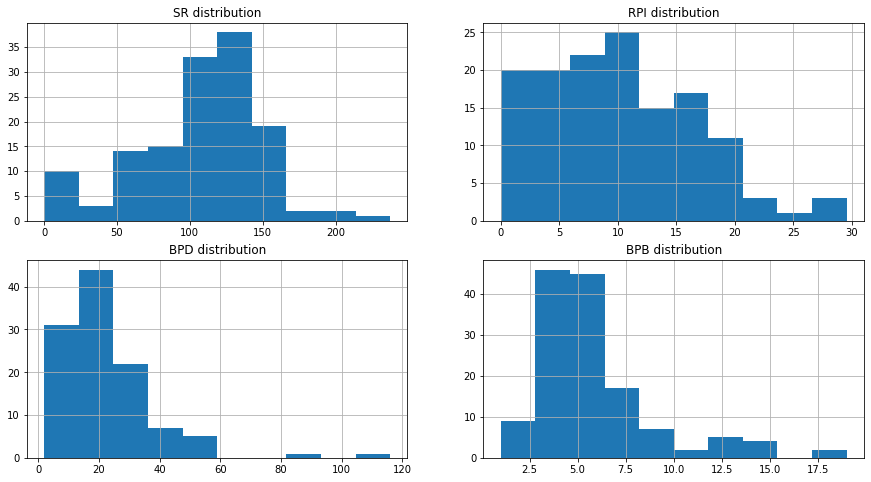

In [18]:
plt.subplot(221)
pp_df.SR.hist()
plt.title('SR distribution')

plt.subplot(222)
pp_df.RPI.hist()
plt.title('RPI distribution')

plt.subplot(223)
pp_df.BPD.hist()
plt.title('BPD distribution')

plt.subplot(224)
pp_df.BPB.hist()
plt.title('BPB distribution')

plt.show()

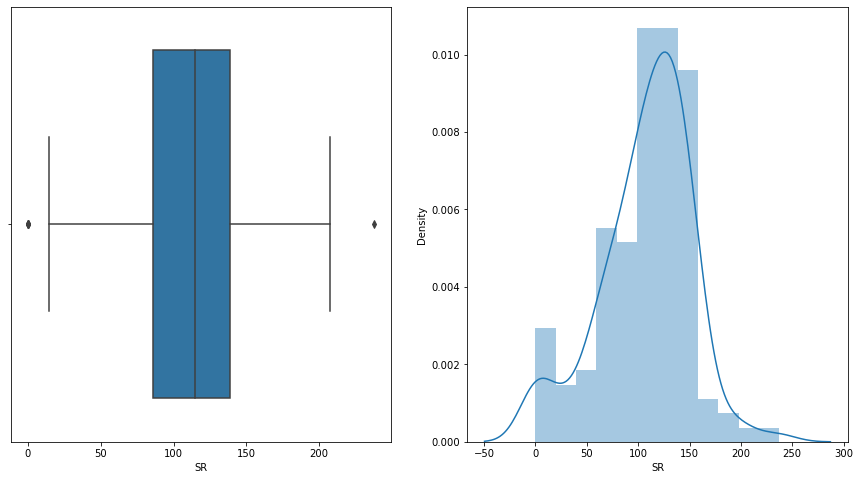

In [19]:
plt.subplot(121)
sns.boxplot(pp_df['SR'])

plt.subplot(122)
sns.distplot(pp_df['SR'])

plt.show()

In [20]:
wt_sr, wt_rpi,wt_bpd,wt_bpb = 0.39, 0.24, 0.12, 0.26

In [21]:
pp_df = pp_df[pp_df.innings > 20]

pp_df.reset_index(inplace= True, drop= True)

In [22]:
pp_df['calc_SR'] = pp_df['SR'].apply(lambda x: x*x)
pp_df['calc_RPI'] = pp_df['RPI'].apply(lambda x: x*x)
pp_df['calc_BPD'] = pp_df['BPD'].apply(lambda x: x*x)
pp_df['calc_BPB'] = pp_df['BPB'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_bpb = np.sqrt(pp_df[['calc_SR', 'calc_RPI', 'calc_BPD', 'calc_BPB']].sum(axis= 0))

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x/sq_sr)
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x/sq_rpi)
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x/sq_bpd)
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x/sq_bpb)

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x*wt_sr)
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x*wt_rpi)
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x*wt_bpd)
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x*wt_bpb)

best_sr, worst_sr = max(pp_df['calc_SR']), min(pp_df['calc_SR'])
best_rpi, worst_rpi = max(pp_df['calc_RPI']), min(pp_df['calc_RPI'])
best_bpd, worst_bpd = max(pp_df['calc_BPD']), min(pp_df['calc_BPD'])
best_bpb, worst_bpb = max(pp_df['calc_BPB']), min(pp_df['calc_BPB'])

In [23]:
pp_df['dev_best_SR'] = pp_df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr))
pp_df['dev_best_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi))
pp_df['dev_best_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd))
pp_df['dev_best_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-best_bpb)*(x-best_bpb))

pp_df['dev_best_sqrt'] = pp_df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_BPB'], axis= 1)

pp_df['dev_worst_SR'] = pp_df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr))
pp_df['dev_worst_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi))
pp_df['dev_worst_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd))
pp_df['dev_worst_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-worst_bpb)*(x-worst_bpb))

pp_df['dev_worst_sqrt'] = pp_df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_BPB'], axis= 1)

In [24]:
pp_df['score'] = pp_df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt']+x['dev_best_sqrt']), axis= 1)

In [26]:
pp_df[['striker', 'innings', 'runs', 'balls', 'dismissals','fours', 'sixes', 'SR', 'BPB', 'score']].sort_values(['score'], ascending= False).reset_index(drop= True).head(25)

,striker,innings,runs,balls,dismissals,fours,sixes,SR,BPB,score
0,YBK Jaiswal,39,815,529,18,122,30,154.064272,3.480263,0.967146
1,Abhishek Sharma,38,715,478,21,85,33,149.581590,4.050847,0.924803
2,P Simran Singh,28,469,319,17,60,22,147.021944,3.890244,0.876352
3,F du Plessis,45,869,611,21,109,36,142.225859,4.213793,0.803856
4,DA Warner,34,649,461,14,94,24,140.780911,3.906780,0.771656
5,SV Samson,30,344,245,6,50,12,140.408163,3.951613,0.760840
6,PP Shaw,26,435,308,17,69,9,141.233766,3.948718,0.734527
7,V Kohli,42,834,611,16,99,28,136.497545,4.811024,0.636347
8,Ishan Kishan,42,797,596,18,99,33,133.724832,4.515152,0.499842
9,RA Tripathi,30,336,250,14,43,13,134.400000,4.464286,0.462918


#### From the above analysis, I conclude that YBK Jaiswal has scored some good runs with a good strike rate in PowerPlay and has also gotten dismissed 18 times which is very good
